# Handwritten digits classification with MLP

## MNIST dataset

### Keras (TF backend) vs Pytorch

In [1]:
# Load frameworks and pacakges
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout

import torch
import torch.nn as nn
import torch.nn.functional as F

print('PyTorch version:', torch.__version__)
print('Keras version:', keras.__version__)
print('Numpy version:', np.__version__)

# Input parameters
use_keras = True
use_torch = True
random_state = 42
batch_size = 128
epochs = 10
neurons = 256, 64


# Define some useful functions
def one_hot_encoding(y):
    """
    Simple one-hot encoder by using numpy
    """
    ohe = np.zeros((y.size, len(np.unique(y))))
    ohe[np.arange(y.size), y.astype('int')] = 1
    return ohe.astype('float32')


def load_dataset():
    """
    Load MNIST dataset from OpenML
    """
    digits = fetch_openml('mnist_784', version=1, cache=True)
    X, y = digits.data, digits.target
    return X, y


def prepare_keras(X, y, test_size=0.15, random_state=1):
    """
    Prepare dataset for Keras. 
    Load dataset as X, y - objects, labels, split for train / test, 
    normalize features, ohe for labes.
    
    You can split data with random seed and specify test size.
    """
    # Split dataset
    x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=random_state)
    # Normalize data
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    # One-hot label encoding
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    return x_train, x_test, y_train, y_test


def mlp_keras(input_shape):
    """
    Create simple NN (as MLP) with Keras.
    
    """
    # Create MLP model
    np.random.seed(random_state)
    model = Sequential(name='MLP')
    model.add(Dense(neurons[0], activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(Dropout(0.5, seed=random_state))
    model.add(Dense(neurons[1], activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5, seed=random_state))
    model.add(Dense(10, activation='softmax'))
    
    print(model.summary())
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def prepare_torch(X, y, batch_size=batch_size, test_size=0.15, random_state=1):
    """
    Prepare dataset for Pytorch. 
    Load dataset as X, y - objects, labels, split for train / test, 
    create tensors and specify loaders
    
    You can split data with random seed and specify test size.
    """
    # Split dataset
    x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=random_state)
    # Normalize data
    x_train = torch.from_numpy(x_train).type(torch.float32)
    x_test = torch.from_numpy(x_test).type(torch.float32)

    y_train = torch.from_numpy(y_train.astype('int'))
    y_test = torch.from_numpy(y_test.astype('int'))

    # Data loader
    train_loader = torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(x_train, y_train),
        batch_size=batch_size,
        shuffle=False
    )
    
    test_loader = torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(x_test, y_test),
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, test_loader


class mlp_torch(nn.Module):
    """
    MLP by using Pytorch classes
    
    """
    def __init__(self):
        super(mlp_torch, self).__init__()
        self.fc1 = nn.Linear(784, neurons[0])
        self.do1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(neurons[0], neurons[1])
        self.do2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(neurons[1], 10)

    def forward(self, X):
        X = X.view(-1, 28 * 28)
        X = F.relu(self.fc1(X))
        X = self.do1(X)
        X = F.relu(self.fc2(X))
        X = self.do2(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)


def train(model, device, epoch, train_loader=None):
    """
    Train procedure for Pytorch model
    
    """
    model.train()
    # Iterate over dataset
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data, target = data.to(device), target.to(device)
        # Zero gradient buffers
        optimizer.zero_grad() 
        # Pass data through the network
        output = model(data)
        # Calculate loss
        loss = criterion(output, target)
        # Backprop
        loss.backward()
        # Update weights
        optimizer.step()
        
        if batch_idx % 250 == 0:
            print('Train Epoch: {} [{:05}/{:05} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))


def validate(model, device, loss_list, accuracy_list, test_loader=None):
    """
    Test (validate) procedure for Pytorch model
    
    """
    model.eval()
    val_loss, correct = 0, 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(test_loader)
    loss_list.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(test_loader.dataset), accuracy))

Using TensorFlow backend.


PyTorch version: 1.4.0
Keras version: 2.3.1
Numpy version: 1.17.0


### Create two models and compare results

[INFO] Load MNIST dataset

[INFO] Prepare Keras dataset

[INFO] Create MLP model

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________
None

Train on 59500 samples, validate on

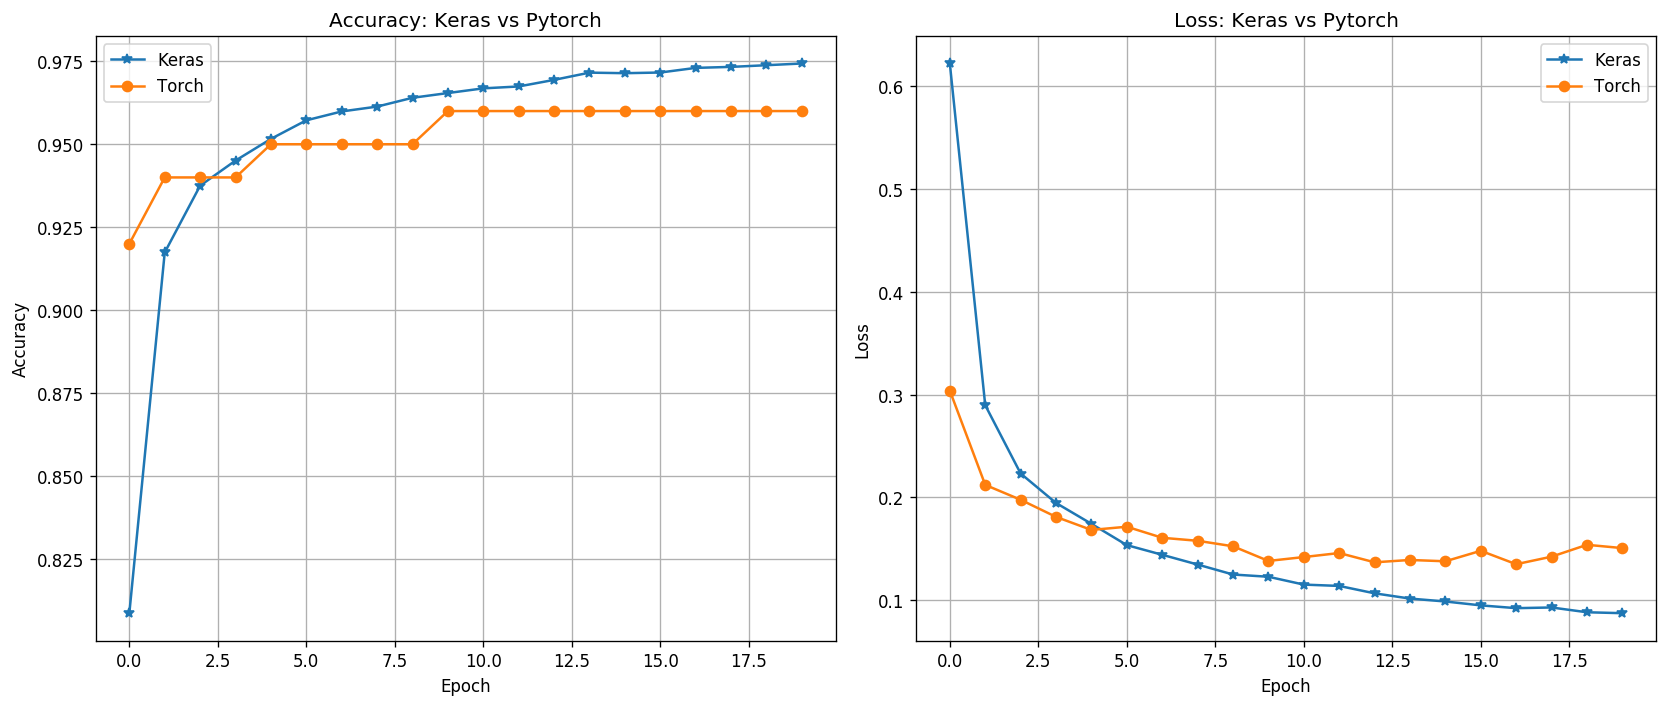

<Figure size 432x288 with 0 Axes>

In [2]:
if __name__ == "__main__":
    
    print('[INFO] Load MNIST dataset\n')
    X, y = load_dataset()
    
    if use_keras:
        print('[INFO] Prepare Keras dataset\n')
        x_train, x_test, y_train, y_test = prepare_keras(X, y, random_state=random_state)
        
        print('[INFO] Create MLP model\n')
        keras_model = mlp_keras(input_shape=(x_train.shape[1], ))
        
        keras_hist = keras_model.fit(x_train, y_train,
                                     batch_size=batch_size,
                                     epochs=epochs,
                                     verbose=2,
                                     workers=4,
                                     validation_data=(x_test, y_test))
        
        print('[INFO] Results for Keras model\n')
        keras_score = keras_model.evaluate(x_test, y_test)
        print(
            f"Test loss     : {keras_score[0]:0.5f}\n"
            f"Test accuracy : {keras_score[1]:0.5f}"
        )

    if use_torch:
        print('\n[INFO] Prepare Torch dataset\n')
        train_loader, test_loader = prepare_torch(X, y, batch_size=batch_size, random_state=random_state)
        
        print('[INFO] Create MLP model\n')
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        torch_model = mlp_torch().to(device)
        optimizer = torch.optim.Adam(torch_model.parameters())
        criterion = nn.CrossEntropyLoss()
        
        print(torch_model)
        
        print('\n[INFO] Results for Torch model\n')
        loss_list, acc_list = [], []
        for epoch in range(1, epochs + 1):
            train(model=torch_model,
                  device=device,
                  epoch=epoch,
                  train_loader=train_loader
                 )

            validate(model=torch_model,
                     device=device,
                     loss_list=loss_list,
                     accuracy_list=acc_list,
                     test_loader=test_loader
                    )
            
        print('\n[INFO] Plot results\n')
        plt.figure('Loss & Accuracy', figsize=(14, 6), dpi=120)
        plt.subplot(1, 2, 1)
        plt.plot(keras_hist.history['accuracy'], '*-')
        plt.plot([int(el)/100 for el in acc_list], 'o-')
        plt.title('Accuracy: Keras vs Pytorch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Keras', 'Torch'], loc='upper left')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(keras_hist.history['loss'], '*-')
        plt.plot(loss_list, 'o-')
        plt.title('Loss: Keras vs Pytorch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Keras', 'Torch'], loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.savefig('Compare_frameworks_mnist_mlp.png')